In [1]:
import bs4; print( 'bs4 ' + bs4.__version__)
from bs4 import BeautifulSoup, SoupStrainer

import sklearn; print( 'sklearn ' + sklearn.__version__)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE

import nltk; print( 'nltk ' + nltk.__version__)
from nltk import word_tokenize, pos_tag, RegexpParser;
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, LancasterStemmer

# from autocorrect import spell; print('autocorrect 0.3.0')

import re; print('re ' + re.__version__)
import requests; print('requests ' + requests.__version__)

import pandas as pd; print('pandas ' + pd.__version__)
import seaborn as sns; print('seaborn ' + sns.__version__)
import numpy as np; print('numpy ' + np.__version__)

import pyLDAvis; print('pyLDAvis ', pyLDAvis.__version__)
import pyLDAvis.sklearn

import matplotlib; print('matplotlib', matplotlib.__version__)
import matplotlib.pyplot as plt;

bs4 4.6.3
sklearn 0.19.1
nltk 3.3
re 2.2.1
requests 2.19.1
pandas 0.22.0
seaborn 0.8.1
numpy 1.14.2
pyLDAvis  2.1.2
matplotlib 2.2.2


# Final Project - Topic Modeling

First we continue where we left off with [Homework 5](https://github.com/kjprice/smu-nlp/blob/e769b93945e6f45ae90aab3ec53b6595ae7bc7da/homework/Homework%205.ipynb).

You can find the source code [here](https://github.com/kjprice/smu-nlp/blob/master/Final%20-%20Topic%20Modeling.ipynb)

### Code from Homework 5


In [2]:
# The home page for various movies' reviews, from which will get the links for individual reviews
review_home_urls = {
    'green_mile': 'https://www.imdb.com/title/tt0120689/reviews?ref_=tt_ql_3',
    'forest_gump': 'https://www.imdb.com/title/tt0109830/reviews?ref_=tt_ov_rt',
    'cast_away': 'https://www.imdb.com/title/tt0162222/reviews?ref_=tt_ov_rt',
    'terminal': 'https://www.imdb.com/title/tt0362227/reviews?ref_=tt_ql_3',
    'catch_me_if_you_can': 'https://www.imdb.com/title/tt0264464/reviews?ref_=tt_ql_3',
    'road_to_perdition': 'https://www.imdb.com/title/tt0257044/reviews?ref_=tt_ql_3',
}
def get_text_from_url(url):
    return requests.get(url).text
text = get_text_from_url(review_home_urls['green_mile'])


In [3]:
def get_all_links_from_html(html):
    tags = BeautifulSoup(html, 'html.parser', parse_only=SoupStrainer('a', href=True))
    urls = [str(tag.attrs['href']) for tag in tags]
    return urls
all_links = get_all_links_from_html(text)

In [4]:
def get_review_urls_from_links(links):
    url_template = 'https://www.imdb.com{}'
    # url_template = 'http://www.gutenberg.org/files/{}/{}-h/{}-h.htm'
    return [url_template.format(link) for link in links]

urls = get_review_urls_from_links(all_links)

In [5]:
def relevent_link(link):
    if '/review/' in link:
        return True
    return False

In [6]:
def get_relevent_links(links):
    relevent_links = filter(relevent_link, links)
    unique_relevent_links = set(relevent_links)
    return list(unique_relevent_links)
relevent_urls = get_relevent_links(urls)
len(relevent_urls)

25

In [7]:
def strain_content(name, attrs):
    if name == 'div' and dict(attrs).get('class', None) == 'content':
        return True
    return False
def clean_review_text(text):
    return re.split('\\n\\n\s+\d+ out of \d+', text)[0]
def get_review_from_url(url):
    html = get_text_from_url(url)
    tags = BeautifulSoup(html, 'html.parser', parse_only=SoupStrainer(strain_content))
    review = clean_review_text(tags.text)
    return review

<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:6: DeprecationWarning: invalid escape sequence \s
<ipython-input-7-fe7ee7139024>:6: DeprecationWarning: invalid escape sequence \s
  return re.split('\\n\\n\s+\d+ out of \d+', text)[0]


In [8]:
def get_review_from_site(url):
    reviews = []

    reviews_home_text = get_text_from_url(url)
    all_links = get_all_links_from_html(reviews_home_text)
    relevent_links = get_relevent_links(all_links)

    review_urls = get_review_urls_from_links(relevent_links)
    for url in review_urls:
        reviews.append(get_review_from_url(url))
        # break
    return reviews

In [9]:
review_home_urls.values()

dict_values(['https://www.imdb.com/title/tt0120689/reviews?ref_=tt_ql_3', 'https://www.imdb.com/title/tt0109830/reviews?ref_=tt_ov_rt', 'https://www.imdb.com/title/tt0162222/reviews?ref_=tt_ov_rt', 'https://www.imdb.com/title/tt0362227/reviews?ref_=tt_ql_3', 'https://www.imdb.com/title/tt0264464/reviews?ref_=tt_ql_3', 'https://www.imdb.com/title/tt0257044/reviews?ref_=tt_ql_3'])

In [10]:
def get_reviews_from_all_sites():
    all_reviews = []
    review_titles = review_home_urls.keys()
    for title in review_titles:
        review_home_url = review_home_urls[title]
        all_reviews = all_reviews + get_review_from_site(review_home_url)
    return all_reviews

## Retrieve All Reviews

In [11]:
all_reviews = get_reviews_from_all_sites()

In [12]:
len(all_reviews)

150

In [13]:
all_reviews[0][0:100]

'\nTHE GREEN MILE (1999) ****Starring: Tom Hanks, David Morse, Michael Clarke Duncan, Bonnie Hunt, Jam'

## Preprocess Data

In [14]:
def sentences_to_words(sentences):
    return [word_tokenize(sentence) for sentence in sentences]
# sentences_to_words([all_reviews[0]])[0][0:5]

In [15]:
custom_stop_words = ['the', 'green', 'mile', 'shawshank', 'redemption', 'one', 'film', 'movie', 'movies', 'tom', 'hanks', 'real', \
                     'act', 'watch', 'frank', 'abagnale', 'dicaprio', 'forest', 'gump', 'jenny', 'leo', 'michael', 'sullivan', \
                     'rooney', 'newman', 'vietnam', 'president', 'second', 'chuck', 'forrest', 'school', 'lawyer', \
                     'airport', 'terminal', 'viktor', 'catherine', 'steven', 'spielberg', 'stephen', 'spielberg', \
                     'navorski', 'island', 'perdition', 'duncan', 'zemeckis', 'son', 'father', 'noland', 'kelly', \
                     'catch', 'walk', 'pilot', 'hanratty', 'christopher', 'road', 'gangster', 'con','away', 'wilson', 'crash',
                     'think', 'like', 'story', 'act', 'every', 'time'
                    ]
stop_words = custom_stop_words + stopwords.words('english')
def remove_stop_words(words):
    return [word for word in words if word not in stop_words]
remove_stop_words(['he', 'her', 'boss', '.', 'the'])

['boss', '.']

In [16]:
def include_only_numbers_and_letters(words):
    regex_matcher = '^[a-zA-Z0-9]+$'
    return [word for word in words if re.match(regex_matcher, word)]
# include_only_numbers_and_letters(['1', 'KJ', '.'])

In [17]:
#stemmer = PorterStemmer()
#stemmer = SnowballStemmer('english')
stemmer = LancasterStemmer()
def lemmatize_word(word):
    lemma_word = stemmer.stem(word)
    if wordnet.synsets(lemma_word):
        return lemma_word
    else:
        return word
def lemmatize_words(words):
    return [lemmatize_word(word) for word in words]
lemmatize_words(['running', 'fastest', 'hats', 'movie'])

['run', 'fastest', 'hat', 'movie']

In [18]:
def preprocess_documents(documents):
    documents_with_formatted_words = [document.lower().strip() for document in documents]
    documents_of_words = sentences_to_words(documents_with_formatted_words)
    content_words_and_characters = [remove_stop_words(words) for words in documents_of_words]
    content_words = [include_only_numbers_and_letters(characters) for characters in content_words_and_characters]
    lematized_words = [lemmatize_words(words) for words in content_words]
    return lematized_words  
preprocess_documents(all_reviews[0:2])[0][0:5]

['1999', 'david', 'mors', 'clark', 'bonny']

In [19]:
documents_of_words = preprocess_documents(all_reviews)
documents_of_words[0][0:7]

['1999', 'david', 'mors', 'clark', 'bonny', 'hunt', 'jam']

### Take a look at words

In [20]:
list_of_all_words = [word for document in documents_of_words for word in document]
len(list_of_all_words)

18807

In [21]:
# Unique Words
len(set(list_of_all_words))

4115

### Flatten documents back to sentences

In [22]:
flattened_documents = [' '.join(document) for document in documents_of_words]

## Perform Topic Modeling

Inspired, in part by https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

In [23]:
# Settings
NUMBER_OF_FEATURES = 1000
NUMBER_OF_TOPICS  = 10
NUMBER_OF_TOP_WORDS = 10

In [24]:
def topics_to_map(model, feature_names, no_top_words):
    map = []
    for topic_idx, topic in enumerate(model.components_):
        stuff = " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        map.append(stuff)
    return map


In [25]:
# Helper function 
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic {}:".format(topic_idx), end=' ')
        stuff = " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        print (stuff)

### Vectorize (Bag Of Words)

In [26]:
tf_vectorizer = TfidfVectorizer(max_features=NUMBER_OF_FEATURES)
tf = tf_vectorizer.fit_transform(flattened_documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [27]:
flattened_documents[0][0:100]

'1999 david mors clark bonny hunt jam cromwell jet doug hutchison gary sin writ direct darabont run 1'

### NMF

In [28]:
nmf = NMF(n_components=NUMBER_OF_TOPICS, random_state=1, alpha=.1, l1_ratio=.4, init='nndsvd').fit(tf)

In [29]:
nmf_topic_map = topics_to_map(nmf, tf_feature_names, NUMBER_OF_TOP_WORDS)
display_topics(nmf, tf_feature_names, NUMBER_OF_TOP_WORDS)

Topic 0: act ev real mak good well see great get life
Topic 1: prison guard edgecomb coffey paul darabont king clark hutchison john
Topic 2: con mend law young cinematography paul hoechlin boss beauty hall
Topic 3: plan fedex volleyball wash nee hunt crash find hel survive
Topic 4: stuck luna passport tucci war stanley attend york pallana flight
Topic 5: best academy award sin perfect win oscar star nominated act
Topic 6: anything innocence mad friend grant life telling eye magnificent love
Topic 7: funny pretend doctor carl tells say watch cut pass want
Topic 8: fake immigrant right attract fantasy rules oh eastern imagination yes
Topic 9: gave whole long hop till emotion weak depth bring giant


### LDA

In [30]:
lda = LatentDirichletAllocation(n_topics=NUMBER_OF_TOPICS, max_iter=50, learning_method='online', learning_offset=50.,random_state=0).fit(tf)



/usr/local/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [31]:
display_topics(lda, tf_feature_names, NUMBER_OF_TOP_WORDS)


Topic 0: thought emotion bet kills etc stop girlfriend collect beauty guess
Topic 1: respect commit seem ready simply rest godfather people control pretend
Topic 2: godfather let yet thing hall nee luna amount intelligent seem
Topic 3: real act mil heart suspect remember perform truth great top
Topic 4: boy author favourite leigh vis right mean perhaps soon eastern
Topic 5: young would without law especially david er spirit dram field
Topic 6: grant robert refuses show put aside lat head maybe war
Topic 7: act best beauty great work ev see seen perform good
Topic 8: good best role felt lie tries see way slight wonderful
Topic 9: could found last relate style shot fir mak superb work


In [32]:
topic_map = nmf.transform(tf)
# topic_map = lda.transform(tf)

# Visualizations

### Word counts per document

In [33]:
number_of_words = [len(review.split(' ')) for review in all_reviews]

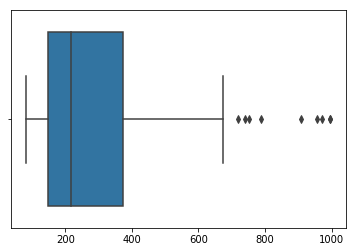

In [34]:
sns.boxplot(number_of_words)

In [35]:
np.median(number_of_words)

216.5

### Scatterplot

With help from https://shuaiw.github.io/2016/12/22/topic-modeling-and-tsne-visualzation.html

In [36]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

In [37]:
tsne_lda = tsne_model.fit_transform(topic_map)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.050288
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.640854
[t-SNE] Error after 1000 iterations: 0.180010


In [38]:
categories = review_home_urls.keys()

In [39]:
categories_vector = []
for category in categories:
    for i in range(int(len(all_reviews) / len(categories))):
        categories_vector.append(category)

In [40]:
primary_topics = [np.argmax(transformed_topics) for transformed_topics in nmf.transform(tf)]
primary_topics_value = [np.max(transformed_topics) for transformed_topics in nmf.transform(tf)]
primary_topics_text = [nmf_topic_map[topic_index] for topic_index in primary_topics]

In [41]:
category_df = pd.DataFrame({
    'x': tsne_lda[:, 0],
    'y': tsne_lda[:, 1],
    'group': categories_vector,
    'primary_topic': primary_topics,
    'primary_topics_text': primary_topics_text,
    'text': flattened_documents
})

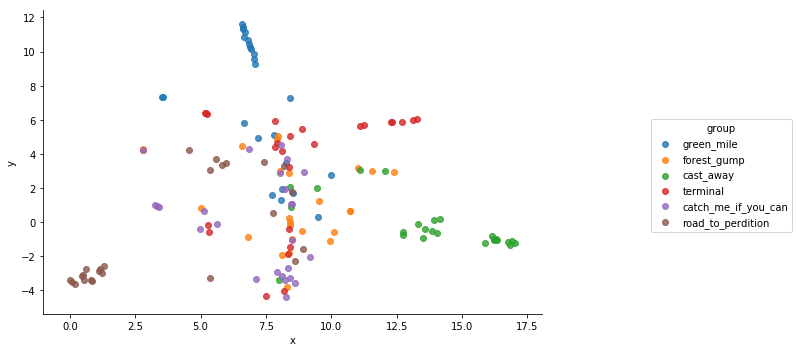

In [42]:
sns.lmplot(x='x', y='y', fit_reg=False, data=category_df, hue='group')
plt.gcf().set_size_inches(12, 5)

### pyLDAvis

In [43]:
# Help by https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(nmf, tf, tf_vectorizer, mds='tsne')
panel

/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
0      56.753488        1       1 -296.284027  154.243622
2       9.773451        1       2 -118.643532   69.777878
3       9.401661        1       3   51.463665 -222.823730
1       6.627984        1       4   45.429497  210.260712
5       4.882103        1       5 -124.148827 -146.104523
4       3.756906        1       6  217.488571  -90.236275
7       3.047182        1       7   39.898861   -5.665255
9       2.225219        1       8 -294.448669  -58.220383
8       1.850043        1       9  215.689774  122.239082
6       1.681964        1      10 -130.265366  286.861725, topic_info=     Category      Freq       Term     Total  loglift  logprob
term                                                          
82    Default  9.000000       best  9.000000  30.0000  30.0000
369   Default  4.000000      funny  4.000000  29.0000  29.0000
530   Default  5.000000       life  5.000000  28.0000  28.0000
959   Default  4.000000      watch  4.000000  27.0000  27.0000
547   Default  3.000000       love  3.000000  26.0000  26.0000
554   Default  4.000000        mad  4.000000  25.0000  25.0000
767   Default  4.000000        say  4.000000  24.0000  24.0000
954   Default  4.000000       want  4.000000  23.0000  23.0000
282   Default  7.000000         ev  7.000000  22.0000  22.0000
37    Default  2.000000   anything  2.000000  21.0000  21.0000
749   Default  3.000000      right  3.000000  20.0000  20.0000
701   Default  3.000000     prison  3.000000  19.0000  19.0000
561   Default  6.000000        mak  6.000000  18.0000  18.0000
961   Default  5.000000        way  5.000000  17.0000  17.0000
476   Default  3.000000   interest  3.000000  16.0000  16.0000
11    Default  7.000000        act  7.000000  15.0000  15.0000
443   Default  3.000000        hop  3.000000  14.0000  14.0000
671   Default  4.000000     people  4.000000  13.0000  13.0000
777   Default  5.000000       seen  5.000000  12.0000  12.0000
699   Default  2.000000    pretend  2.000000  11.0000  11.0000
540   Default  3.000000       long  3.000000  10.0000  10.0000
674   Default  5.000000    perform  5.000000   9.0000   9.0000
132   Default  4.000000  character  4.000000   8.0000   8.0000
968   Default  2.000000      whole  2.000000   7.0000   7.0000
125   Default  4.000000       cast  4.000000   6.0000   6.0000
292   Default  2.000000     expect  2.000000   5.0000   5.0000
622   Default  3.000000      never  3.000000   4.0000   4.0000
719   Default  6.000000       real  6.000000   3.0000   3.0000
668   Default  3.000000       paul  3.000000   2.0000   2.0000
991   Default  4.000000      would  4.000000   1.0000   1.0000
...       ...       ...        ...       ...      ...      ...
882   Topic10  0.522983    telling  1.035298   3.4023  -3.5892
10    Topic10  0.413819     across  0.825355   3.3948  -3.8234
518   Topic10  0.431713      leave  0.878071   3.3752  -3.7810
37    Topic10  1.415687   anything  2.929395   3.3580  -2.5934
377   Topic10  0.413063        gen  1.106446   3.0999  -3.8252
601   Topic10  0.412814       moth  1.146142   3.0640  -3.8258
819   Topic10  0.387899  sometimes  1.130695   3.0154  -3.8880
568   Topic10  0.361202        mat  1.071832   2.9975  -3.9594
300   Topic10  0.520143        eye  1.586335   2.9701  -3.5947
365   Topic10  0.696270     friend  2.535560   2.7928  -3.3031
877   Topic10  0.424657      teach  1.598138   2.7599  -3.7975
743   Topic10  0.353896     review  1.334695   2.7578  -3.9798
665   Topic10  0.430416       pass  1.667072   2.7311  -3.7840
76    Topic10  0.358888     behind  1.458886   2.6828  -3.9658
280   Topic10  0.038220        etc  0.163893   2.6294  -6.2054
325   Topic10  0.451390       felt  1.966766   2.6134  -3.7365
99    Topic10  0.358117        boy  1.750779   2.4983  -3.9679
36    Topic10  0.384264     anyone  1.887668   2.4934  -3.8975
102   Topic10  0.338852  brilliant  1.667757   2

### Heatmap

In [44]:
words = tf_vectorizer.get_feature_names()

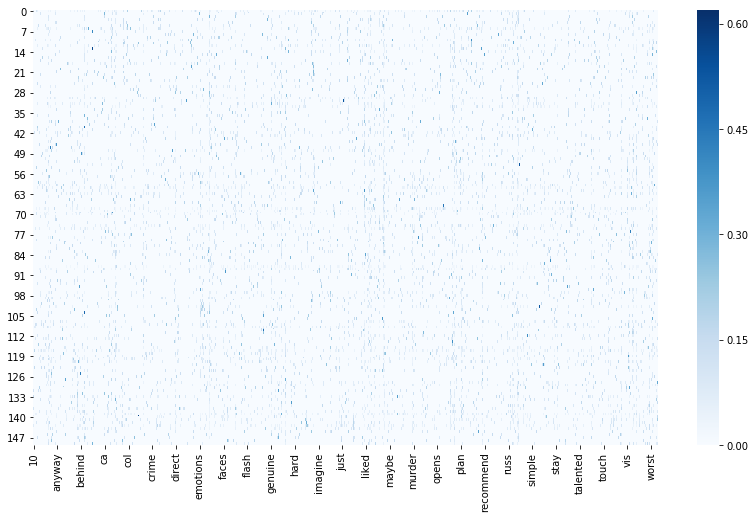

In [45]:
sns.heatmap(pd.DataFrame(tf.todense(), columns=words), cmap='Blues')
plt.gcf().set_size_inches(14, 8)

### Frequency of categories and topics

In [46]:
category_df[category_df['primary_topics_text'] == 'products art never us cent provide profit unfortunately expense pond']

,group,primary_topic,primary_topics_text,text,x,y


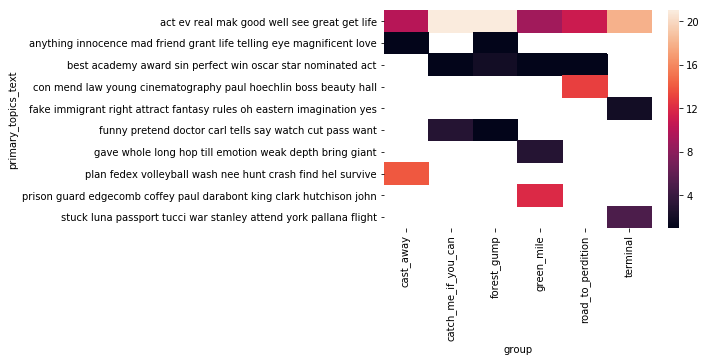

In [47]:
sns.heatmap(category_df.groupby(['primary_topics_text', 'group']).size().unstack())

In [48]:
category_df.groupby(['primary_topics_text', 'group']).size().unstack()

group,cast_away,catch_me_if_you_can,forest_gump,green_mile,road_to_perdition,terminal
primary_topics_text,,,,,,
act ev real mak good well see great get life,10.0,21.0,21.0,9.0,11.0,18.0
anything innocence mad friend grant life telling eye magnificent love,1.0,NaN,1.0,NaN,NaN,NaN
best academy award sin perfect win oscar star nominated act,NaN,1.0,2.0,1.0,1.0,NaN
con mend law young cinematography paul hoechlin boss beauty hall,NaN,NaN,NaN,NaN,13.0,NaN
fake immigrant right attract fantasy rules oh eastern imagination yes,NaN,NaN,NaN,NaN,NaN,2.0
funny pretend doctor carl tells say watch cut pass want,NaN,3.0,1.0,NaN,NaN,NaN
gave whole long hop till emotion weak depth bring giant,NaN,NaN,NaN,3.0,NaN,NaN
plan fedex volleyball wash nee hunt crash find hel survive,14.0,NaN,NaN,NaN,NaN,NaN
prison guard edgecomb coffey paul darabont king clark hutchison john,NaN,NaN,NaN,12.0,NaN,NaN
